In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

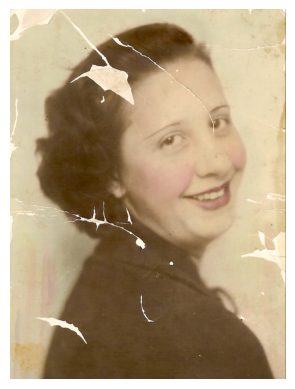

In [78]:
# Original Image: image

image = cv2.imread('old_images/old_image1.png')

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

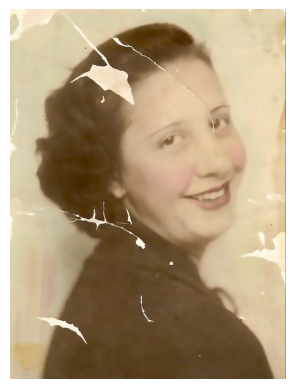

In [79]:
# Denoised Image: denoised_image

denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

plt.imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

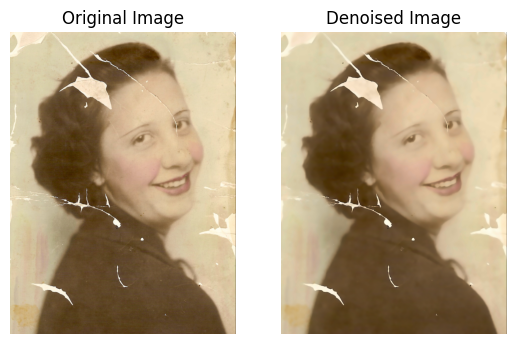

In [80]:
# Comparison: Original Image vs Denoised Image

plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB)), plt.title('Denoised Image')
plt.axis('off')
plt.show()

In the cells below, we construct a scratch_mask for the image.

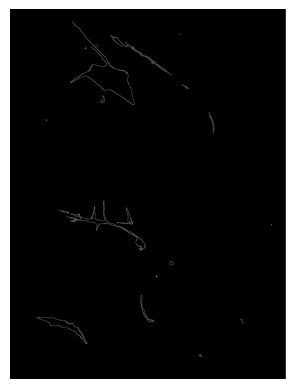

In [81]:
# Gaussian blur to reduce noise in the edge detection process
blurred_image = cv2.GaussianBlur(denoised_image, (3, 3), 0)

# Canny edge detection
scratch_mask = cv2.Canny(blurred_image, 40, 300)

plt.imshow(scratch_mask, cmap = 'gray', vmin = 0, vmax = 255)
plt.axis('off')
plt.show()

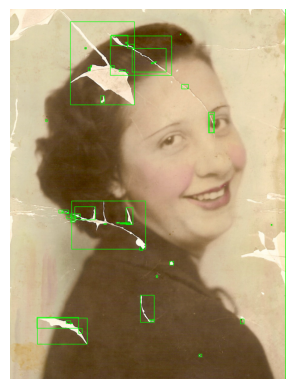

In [82]:
# Contours of the detected edges
contours, _ = cv2.findContours(scratch_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Bounding boxes of the detected contours
bounding_boxes = [cv2.boundingRect(contour) for contour in contours]


# Displaying bounding boxes on the Original Image

bounded_image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

for x, y, w, h in bounding_boxes:
    cv2.rectangle(bounded_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(bounded_image)
plt.axis('off')
plt.show()

A few of the contours enclose some inherent parts of the image. We filter out such contours in the cell below. To do so, we relied on an intuitive property of scartches that they have pixels with almost similar intensities.

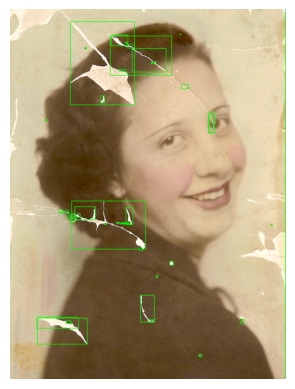

In [83]:
scratch_contours = []

for contour in contours:
    # Pixel intensities enclosed by the contour
    mask = np.zeros_like(scratch_mask)
    cv2.drawContours(mask, [contour], -1, (255), thickness = cv2.FILLED)
    enclosed_pixels = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)[mask == 255]

    # Standard deviation of pixel intensities
    std_dev = np.std(enclosed_pixels)

    # Classify contours based on standard deviation
    if std_dev > 10:
        scratch_contours.append(contour)


# Drawing contours of scratches on the original image

bounding_boxes = [cv2.boundingRect(contour) for contour in scratch_contours]
bounded_image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

for x, y, w, h in bounding_boxes:
    cv2.rectangle(bounded_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(bounded_image)
plt.axis('off')
plt.show()

To fill in the regions of scratches, we apply morphological closing. The kernel size for such operation is calculated dynamically for each image depending on the average scratch size.

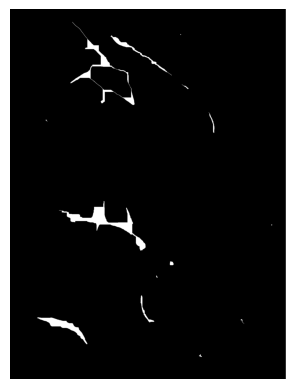

In [84]:
average_scratch_size = np.mean([w * h for x, y, w, h in bounding_boxes])

# Kernel size based on scratch size
kernel_size_factor = int(np.sqrt(average_scratch_size)/2)
kernel_size = (kernel_size_factor, kernel_size_factor)
kernel = np.ones(kernel_size, np.uint8)

# Morphological closing to fill regions bounded by edges
scratch_mask = cv2.morphologyEx(scratch_mask, cv2.MORPH_CLOSE, kernel)

plt.imshow(scratch_mask, cmap = 'gray', vmin = 0, vmax = 255)
plt.axis('off')
plt.show()

We apply the scratch_mask on the Denoised Image and inpaint the scratched regions identified. To do so we apply Gaussian Pyramid, inpaint the downsampled image using Telea algorithm, and upsample the image using cubic interpolation. The cell below shows the reconstructed image obtained after each iteration upto 6 iterations.

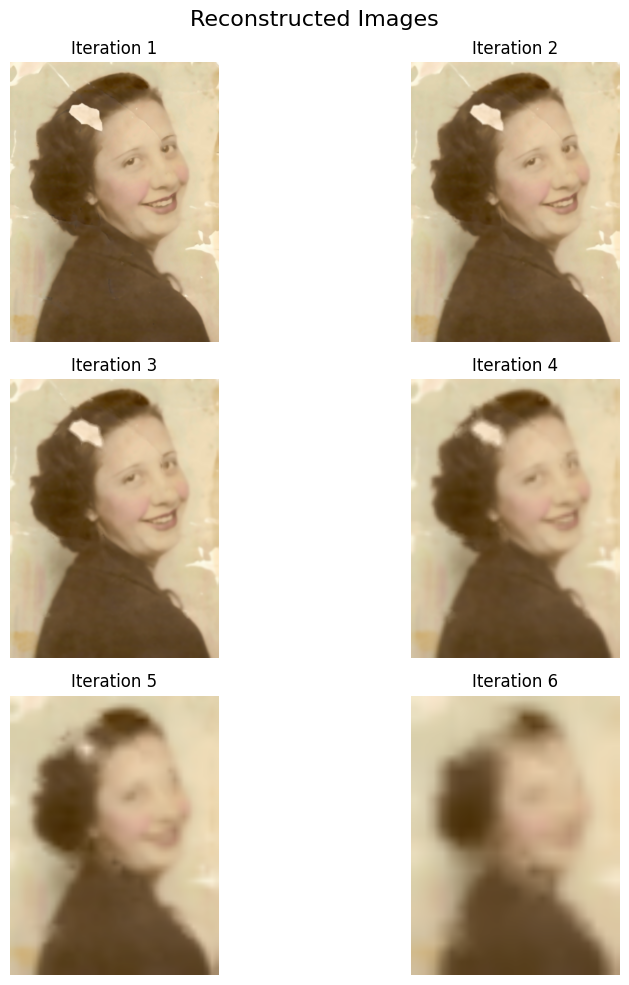

In [85]:
layer = denoised_image.copy()
layer_scratch_mask = scratch_mask.copy()

reconstructed_images = []

plt.figure(figsize = (10, 10))

for i in range(6):
    plt.subplot(3, 2, i + 1)

    # Downsample the image and the scratch mask
    layer = cv2.pyrDown(layer)
    layer_scratch_mask = cv2.pyrDown(layer_scratch_mask)

    # Inpaint using TELEA algorithm to remove scratches
    inpainted_layer = cv2.inpaint(layer, layer_scratch_mask, inpaintRadius = 3, flags = cv2.INPAINT_TELEA)

    # Upsample the inpainted image to its original size using cubic interpolation
    layer_upsampled = cv2.resize(inpainted_layer, (denoised_image.shape[1], denoised_image.shape[0]), interpolation = cv2.INTER_LINEAR)
    reconstructed_images.append(layer_upsampled)

    plt.imshow(cv2.cvtColor(layer_upsampled, cv2.COLOR_BGR2RGB))
    plt.title(f'Iteration {i+1}')
    plt.axis('off')

plt.suptitle('Reconstructed Images', fontsize = 16)
plt.tight_layout()
plt.show()

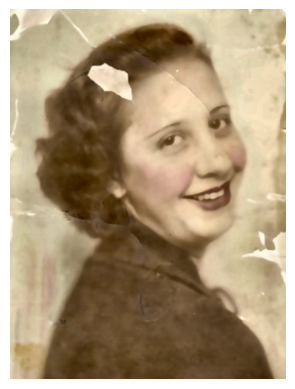

In [86]:
reconstructed_image = reconstructed_images[0] # We choose the best reconstructed image.

# Image in LAB color space
lab = cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2LAB)

l, a, b = cv2.split(lab)

# Applying CLAHE to the L channel
clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
l_enhanced = clahe.apply(l)

lab_enhanced = cv2.merge((l_enhanced, a, b))

enhanced_image = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2RGB)

plt.imshow(enhanced_image)
plt.axis('off')
plt.show()

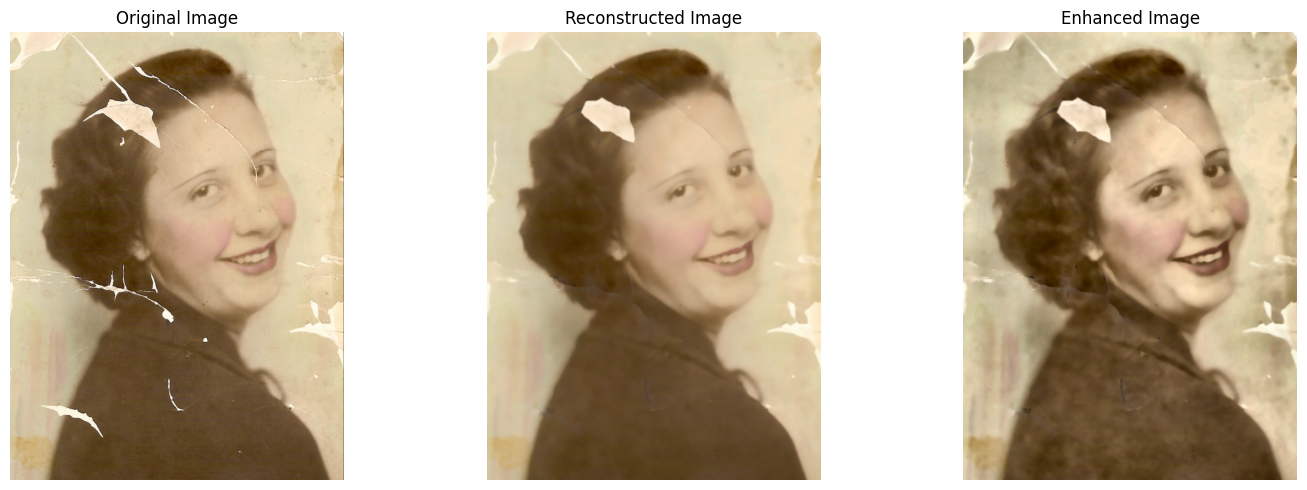

In [87]:
# Comparison: Original Image vs Reconstructed Image vs Enhanced Image

plt.figure(figsize = (15, 5))

# Original Image
plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Reconstructed Image
plt.subplot(132)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))
plt.title('Reconstructed Image')
plt.axis('off')

# Enhanced Image
plt.subplot(133)
plt.imshow(enhanced_image)
plt.title('Enhanced Image')
plt.axis('off')

plt.tight_layout()
plt.show()